In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
outfolder = '211205_additional_single_cell'

In [5]:
save_images = True

In [6]:
p = export.get_material_path(
    '200612_probe_single_cell_differential_sum_of_raw/stats_200612_0951.xlsx')

In [7]:
df = pd.read_excel(p)

In [8]:
df['organ'] = df['organ'].str.replace(
    '_facs', '').str.replace('_droplet', '').str.replace('_', ' ').str.capitalize()

In [9]:
df['cell_type'] = df['cell_type'].str.capitalize()

In [10]:
df = df[df['shared'].isin(
    ['tabula_muris_facs_24', 'tabula_muris_10x_24', 'calico_22']
)].copy()

In [11]:
f = (df['rho'] < 0) & (df['pval'] < 0.01)
df.loc[f, 'sign'] = -1

f = (df['rho'] > 0) & (df['pval'] < 0.01)
df.loc[f, 'sign'] = +1

f = (df['pval'] >= 0.01)
df.loc[f, 'sign'] = 0



In [12]:
df['composite'] = df['shared'] + '_' + df['organ']

In [13]:
df_export = df[['dataset', 'organ', 'cell_type', 'rho', 'pval']].rename(
    columns={'rho': 'rho_transcriptome_imbalance'}
).sort_values(['dataset', 'organ', 'cell_type'])

In [14]:
if save_images:
    export.export_full_frame(
        '{}/singel_cell_imbalances.xlsx'.format(
                outfolder),
        df_export,
        save_index=False,
        insert_date_time=False
    )

In [15]:
from itertools import product

from scipy.stats import mannwhitneyu

In [16]:
df_export.groupby(['dataset', 'organ']).size()

dataset            organ            
calico             Kidney               11
                   Lung                 13
                   Spleen                4
tabula_muris_10x   Bladder               4
                   Heart                 7
                   Kidney                5
                   Limb muscle           9
                   Liver                 5
                   Spleen                8
                   Thymus                5
                   Tongue                3
tabula_muris_facs  Bladder               2
                   Brain myeloid         2
                   Brain non-myeloid    12
                   Diaphragm             6
                   Heart                 8
                   Kidney                9
                   Large intestine       7
                   Limb muscle           6
                   Liver                 7
                   Lung                 11
                   Marrow               18
                 

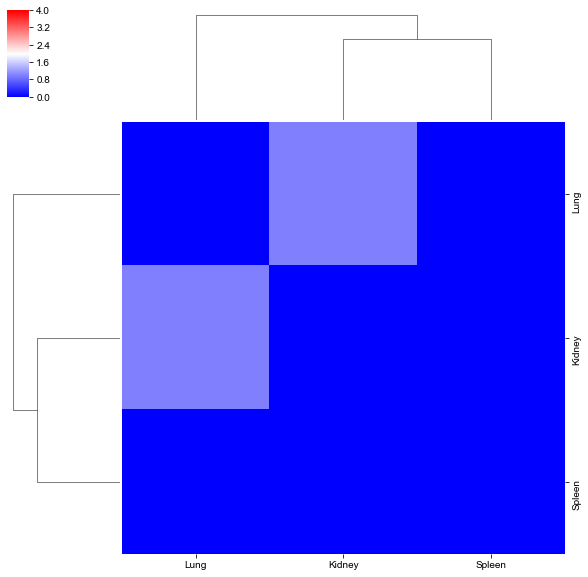

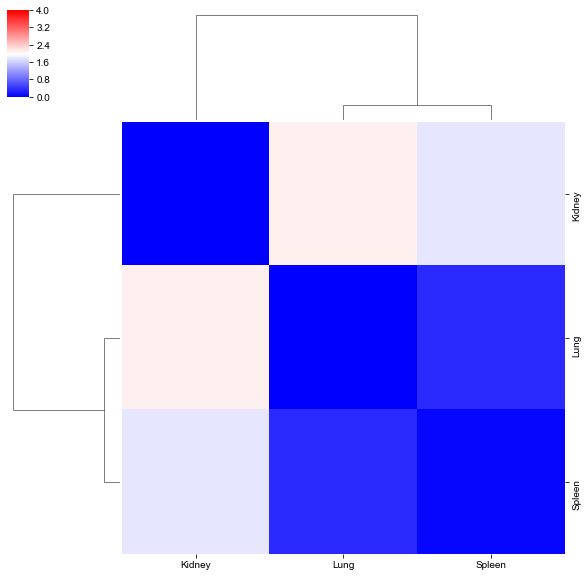

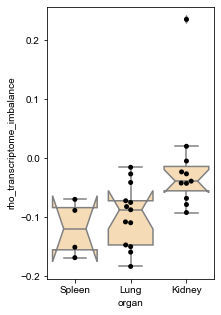

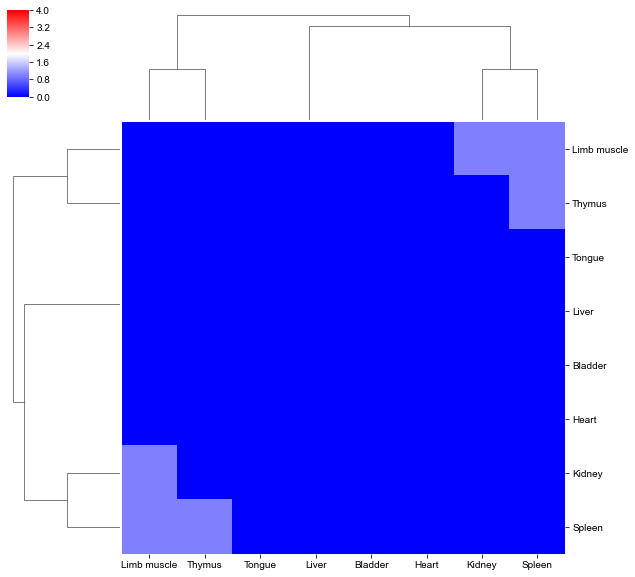

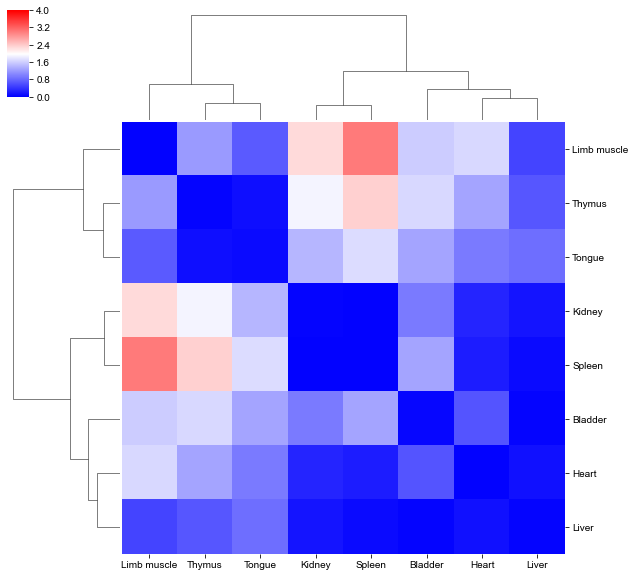

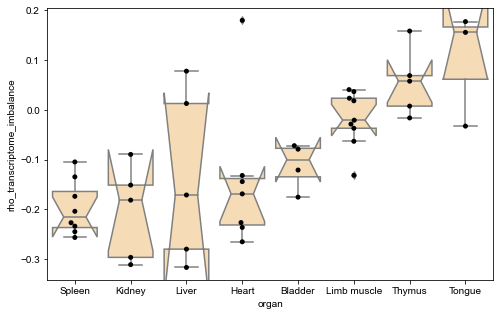

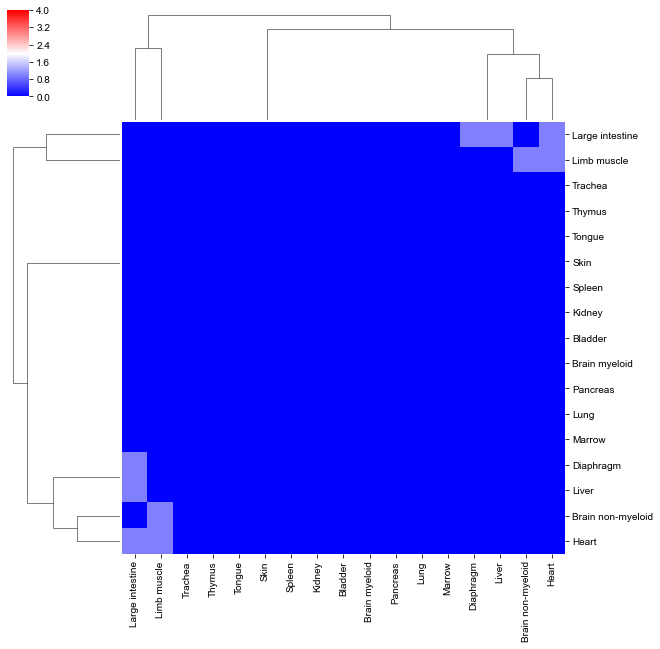

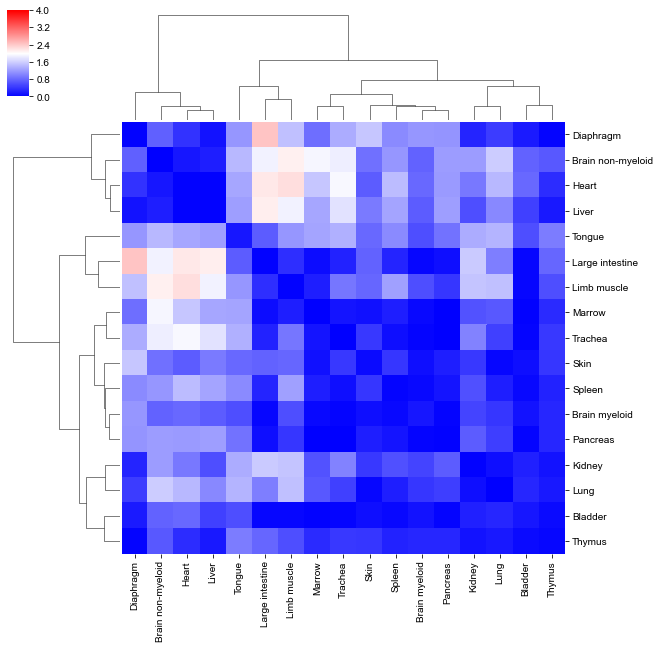

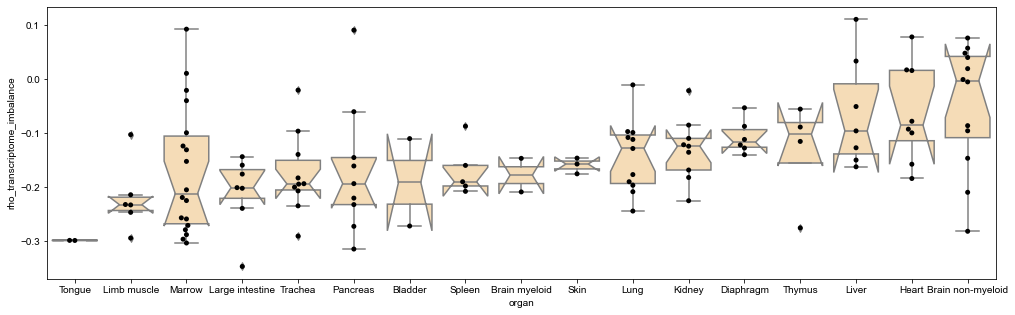

In [17]:
for dataset in df_export['dataset'].unique():

    q = df_export[df_export['dataset']==dataset]
    
    organs = q['organ'].unique()

    results = pd.DataFrame(index=organs, columns=organs)


    for x, y in product(organs, organs):

        a = q[q['organ']==x]['rho_transcriptome_imbalance']
        b = q[q['organ']==y]['rho_transcriptome_imbalance']

        res = mannwhitneyu(a, b, alternative='two-sided')[1]
        results.loc[x, y] = res

    sns.clustermap(
        results.astype(float).apply(lambda x: -np.log10(x)>2), vmin=0, vmax=4, cmap='bwr', method='ward')
    export.export_image(
        '{}/{}_corr_threshold.pdf'.format(
            outfolder, dataset))               
               
               

    sns.clustermap(
        results.astype(float).apply(lambda x: -np.log10(x)), vmin=0, vmax=4, cmap='bwr', method='ward')
    export.export_image(
        '{}/{}_corr.pdf'.format(
            outfolder, dataset))               
               
            
    
    plt.figure(figsize=(len(q['organ'].unique()), 5))
    sns.boxplot(
        x='organ',
        y='rho_transcriptome_imbalance',
        data=q,
        notch=True,
        order=q.groupby('organ')['rho_transcriptome_imbalance'].median().sort_values().index,
        color='navajowhite'
    )
    sns.swarmplot(
        x='organ',
        y='rho_transcriptome_imbalance',
        data=q,
        order=q.groupby('organ')['rho_transcriptome_imbalance'].median().sort_values().index,
        color='black'
    )


               
    export.export_image(
        '{}/{}_box.pdf'.format(
            outfolder, dataset))

In [18]:
q = df_export[df_export['dataset']=='tabula_muris_10x']

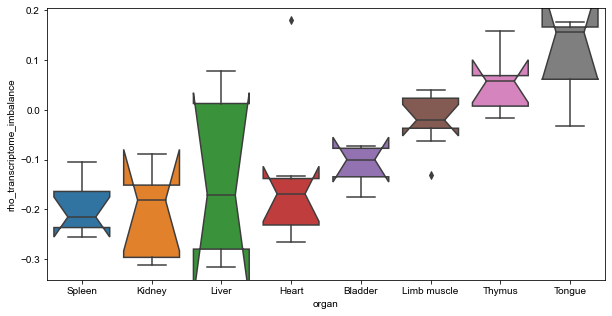

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    x='organ',
    y='rho_transcriptome_imbalance',
    data=q,
    notch=True,
    order=q.groupby('organ')['rho_transcriptome_imbalance'].median().sort_values().index

)

In [20]:
df_export['dataset'].value_counts()

tabula_muris_facs    121
tabula_muris_10x      46
calico                28
Name: dataset, dtype: int64

In [21]:
df

,older,organ,cell_type,rho,pval,dataset,shared,sign,composite
0,22,Lung,B cell,-0.087221,2.122608e-13,calico,calico_22,-1.0,calico_22_Lung
1,22,Lung,T cell,-0.109168,4.093348e-20,calico,calico_22,-1.0,calico_22_Lung
2,22,Lung,Alveolar macrophage,-0.081887,1.652837e-11,calico,calico_22,-1.0,calico_22_Lung
3,22,Lung,Ciliated columnar cell of tracheobronchial tree,-0.015438,3.132353e-01,calico,calico_22,0.0,calico_22_Lung
4,22,Lung,Classical monocyte,-0.183017,4.098435e-53,calico,calico_22,-1.0,calico_22_Lung
...,...,...,...,...,...,...,...,...,...
395,24,Thymus,Professional antigen presenting cell,0.007659,5.266041e-01,tabula_muris_10x,tabula_muris_10x_24,0.0,tabula_muris_10x_24_Thymus
398,24,Thymus,Thymocyte,0.068965,2.628429e-07,tabula_muris_10x,tabula_muris_10x_24,1.0,tabula_muris_10x_24_Thymus
399,24,Tongue,Langerhans cell,-0.032558,9.061190e-03,tabula_muris_10x,tabula_muris_10x_24,-1.0,tabula_muris_10x_24_Tongue
401,24,Tongue,Basal cell of epidermis,0.155835,1.148233e-53,tabula_muris_10x,tabula_muris_10x_24,1.0,tabula_muris_10x_24_Tongue


In [22]:
m = df.pivot(
    index='composite',
    columns='cell_type',
    values='rho'
)

In [23]:
mm = m.copy()

In [24]:
mm.index = [x.replace('calico_22_', 'C ') for x in mm.index]

In [25]:
mm.index = [x.replace('tabula_muris_10x_24_', 'TM ') for x in mm.index]

In [26]:
mm.index = [x.replace('tabula_muris_facs_24_', 'TF ') for x in mm.index]

In [27]:
mm = mm.sort_index()

In [28]:
is_null = mm.isnull()

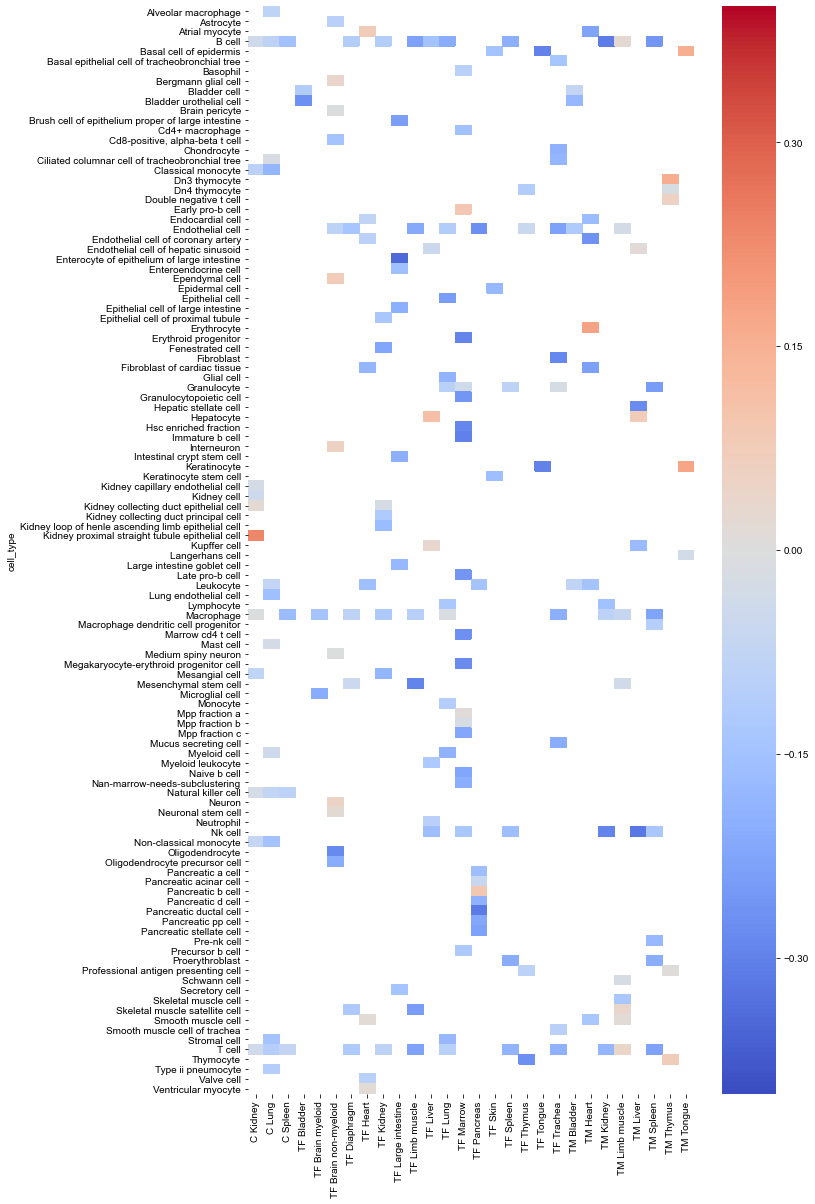

In [29]:
plt.figure(figsize=(10, 20))

sns.heatmap(
    mm.fillna(0).transpose(), 
    cmap='coolwarm',
    mask=is_null.transpose(),
    xticklabels=True,
    yticklabels=True,
    vmin=-0.4,
    vmax=0.4

)

if save_images:
    export.export_image(
        '{}/direction_model_organisms.pdf'.format(
            outfolder))